# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

## Physical Models of target and interceptor

In [2]:
from models.missile import PhysicalMissleModel
import models.physics as physics
import numpy as np

interceptor_speed = physics.mach_to_ms(4.0)  # Speed of the interceptor in m/s
target_speed = physics.mach_to_ms(3.0)  # Speed of the target in m/s
target = PhysicalMissleModel(velocity=np.array([0, target_speed, 0.0]), max_acc=100 * 9.81, pos=np.array([0.0, -10_000, 15_000.0]))
interceptor = PhysicalMissleModel(velocity=np.array([0.0, 0.0, interceptor_speed]), max_acc=100 * 9.81, pos=np.array([0.0, 0.0, 100.0]))

## Environment & Gym

In [3]:
from gym.environment import MissileEnv, MissileEnvSettings
from pilots.random_evasion_pilot import RandomEvasionPilot

# target behavior
target_pilot = RandomEvasionPilot(aggression=0.2, trajectory_maintainance=0.01)

settings = MissileEnvSettings()
settings.time_step = 0.01    # Time step for the simulation
settings.realtime = False    # Runs faster than real-time
settings.time_limit = 50.0  # Time-limit for the episode
env = MissileEnv(settings=settings, target=target, interceptor=interceptor, target_pilot=target_pilot)

# Proportional Guidance

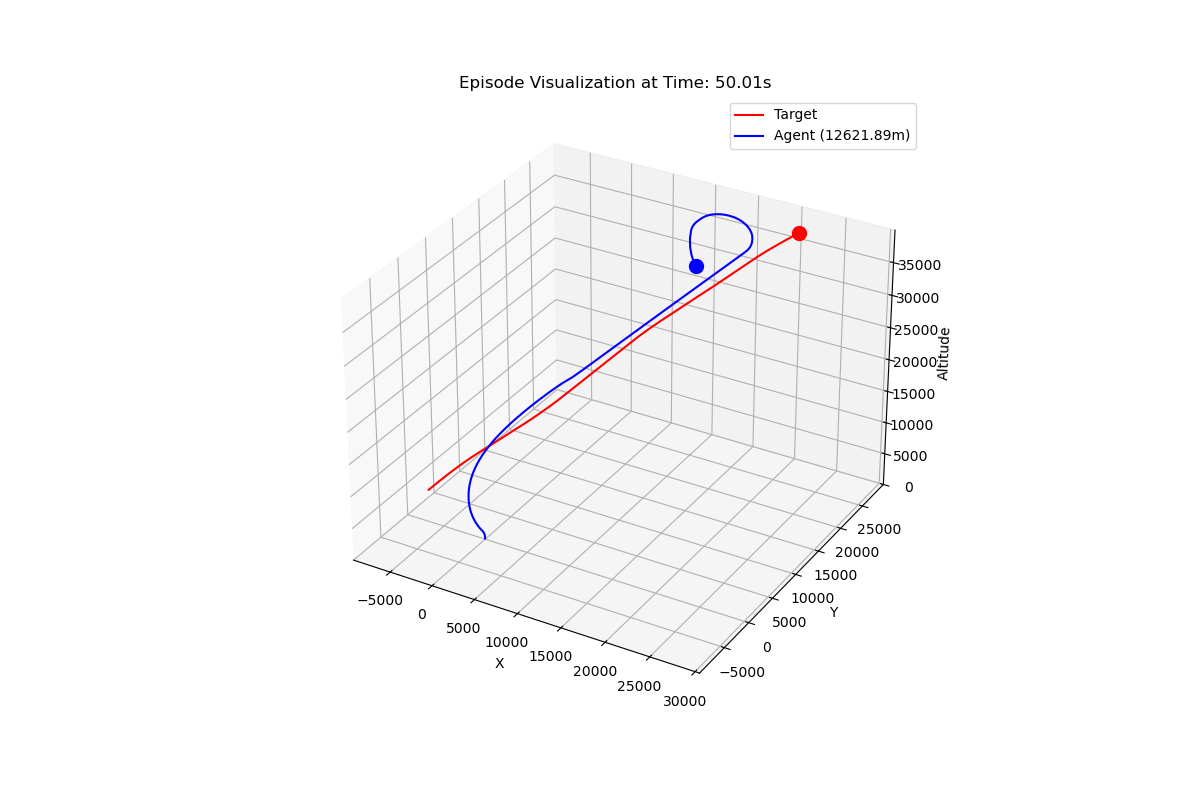

In [4]:
from pilots.proportional_nav_pilot import ProportionalNavigationPilot
from visualization.matplot_viz import MatplotVisualizer
import time


# setup pilots
proportional_nav_pilot = ProportionalNavigationPilot(max_acc=100*9.81, max_speed=interceptor_speed, n=7.0)


done = False
obs, _ = env.reset()

viz = MatplotVisualizer()
viz.set_episode_data(env.current_episode)

last_time = time.time()
max_render_fps = 10.0

while not done:
    # get un-normalized observations for the interceptor (environment outputs normalized observations for RL agent)
    obs = env.get_interceptor_observations(settings.time_step).pack()

    # pilot the interceptor using the proportional navigation algorithm
    action = proportional_nav_pilot.step(obs, settings.time_step)
    obs, reward, done, _, _ = env.step(action)  # Take a step in the environment
    
# viz.playback(env.sim_time, speed=5.0)
viz.render(env.sim_time)

# Reinforcement Learning Agents

## Soft Actor-Critic

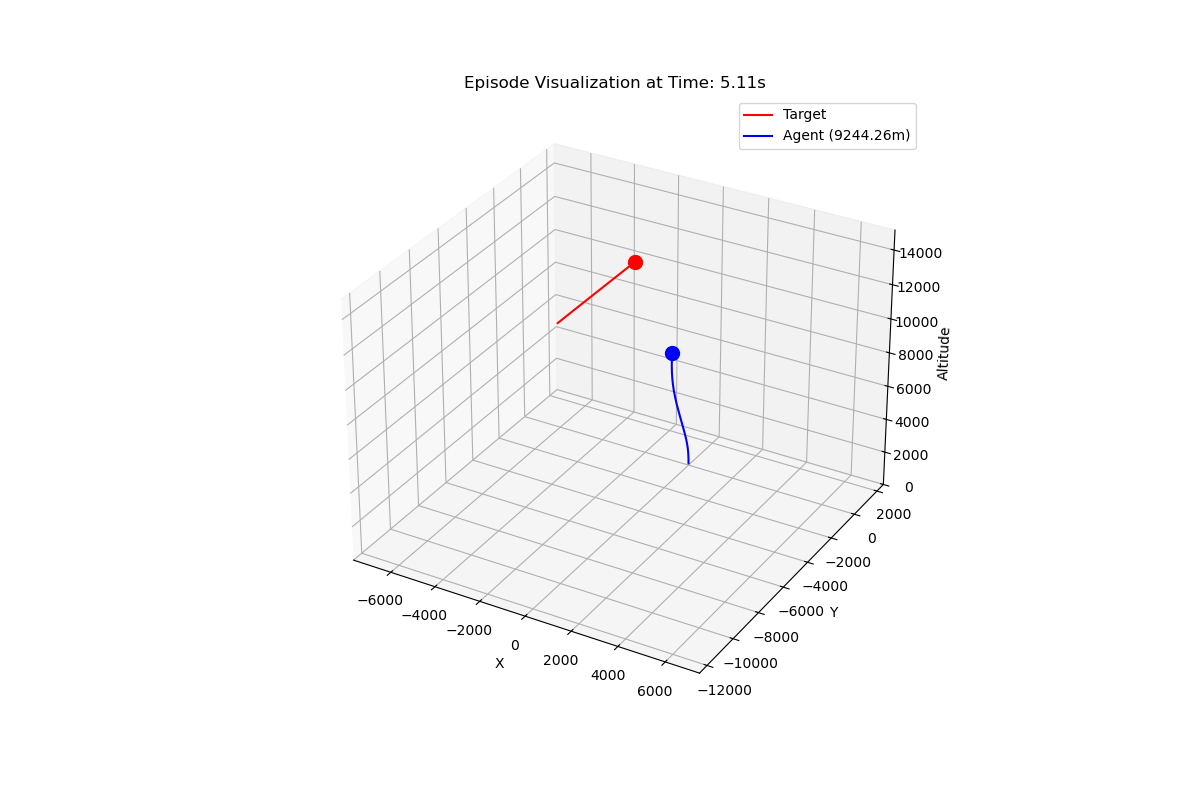

In [5]:
from stable_baselines3 import SAC
from tqdm import tqdm

model = SAC("MlpPolicy", env, verbose=1, tensorboard_log="./.logs/sac", device="cuda")
with tqdm(total=100_000, desc="Training Progress", unit="steps") as pbar:
    model.learn(total_timesteps=100_000, progress_bar=pbar)

viz.set_episode_data(env.current_episode)
viz.render(env.sim_time)

In [6]:
def get_best_distance(episode):
    # get the best distance between the interceptor and the target
    return min([state.distance for time, state in env.current_episode.get_interceptor("Agent").states.all.items()])

print(f"Best distance: {get_best_distance(env.current_episode)} m")

Best distance: 9244.264701244585 m


In [ ]:
# Train until desired results
complete = False
while not complete:
    with tqdm(total=10_000, desc="Training Progress", unit="steps") as pbar:
        model.learn(total_timesteps=10_000, progress_bar=pbar)

    eval_distances = []
    for i in range(10):
        done = False
        while not done:
            obs = env.get_interceptor_observations(settings.time_step).pack()
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env.step(action)

        best_distance = min([state.distance for time, state in env.current_episode.get_interceptor("Agent").states.all.items()])
        eval_distances.append(best_distance)
    
    mean_distance = np.mean(eval_distances)
    print(f"Mean distance: {mean_distance:.2f} m")
    
    if mean_distance < 100.0:
        complete = True
        print(f"Training complete! Mean distance: {mean_distance:.2f} m")

Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_119


Output()

Training Progress:   0%|          | 0/10000 [01:37<?, ?steps/s]


Mean distance: 7306.67 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_120


Output()

Training Progress:   0%|          | 0/10000 [01:37<?, ?steps/s]


Mean distance: 2468.11 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_121


Output()

Training Progress:   0%|          | 0/10000 [01:37<?, ?steps/s]


Mean distance: 3578.98 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_122


Output()

Interceptor crashed into the ground

Training Progress:   0%|          | 0/10000 [01:38<?, ?steps/s]


Mean distance: 3576.54 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_123


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 3330.68 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_124


Output()

Training Progress:   0%|          | 0/10000 [01:37<?, ?steps/s]


Mean distance: 2450.43 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_125


Output()

Training Progress:   0%|          | 0/10000 [01:39<?, ?steps/s]


Mean distance: 2803.38 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_126


Output()

Training Progress:   0%|          | 0/10000 [01:35<?, ?steps/s]


Mean distance: 2617.55 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_127


Output()

Training Progress:   0%|          | 0/10000 [01:35<?, ?steps/s]


Mean distance: 3686.77 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_128


Output()

Training Progress:   0%|          | 0/10000 [01:35<?, ?steps/s]


Mean distance: 3262.03 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_129


Output()

Training Progress:   0%|          | 0/10000 [01:35<?, ?steps/s]


Mean distance: 1814.07 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_130


Output()

Training Progress:   0%|          | 0/10000 [01:35<?, ?steps/s]


Mean distance: 3522.39 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_131


Output()

Training Progress:   0%|          | 0/10000 [01:35<?, ?steps/s]


Mean distance: 3384.51 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_132


Output()

Interceptor crashed into the ground

Interceptor crashed into the ground

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 3790.56 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_133


Output()

Training Progress:   0%|          | 0/10000 [01:35<?, ?steps/s]


Mean distance: 1598.73 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_134


Output()

Training Progress:   0%|          | 0/10000 [01:35<?, ?steps/s]


Mean distance: 1971.25 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_135


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 1784.19 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_136


Output()

Interceptor crashed into the ground

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 1454.84 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_137


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 657.38 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_138


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 163.85 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_139


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 890.72 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_140


Output()

Interceptor crashed into the ground

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 3205.85 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_141


Output()

Interceptor crashed into the ground

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 10585.42 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_142


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 2614.79 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_143


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 6683.02 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_144


Output()

Interceptor crashed into the ground

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 12427.58 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_145


Output()

Interceptor crashed into the ground

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 12537.66 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_146


Output()

Interceptor crashed into the ground

Interceptor crashed into the ground

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 8778.83 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_147


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 5281.15 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_148


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 3252.16 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_149


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 3344.11 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_150


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 4300.74 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_151


Output()

Interceptor crashed into the ground

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 12383.03 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_152


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 1306.99 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_153


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 3074.79 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_154


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 401.33 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_155


Output()

Training Progress:   0%|          | 0/10000 [01:38<?, ?steps/s]


Mean distance: 484.63 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_156


Output()

Interceptor crashed into the ground

Training Progress:   0%|          | 0/10000 [01:37<?, ?steps/s]


Mean distance: 448.04 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_157


Output()

Training Progress:   0%|          | 0/10000 [01:38<?, ?steps/s]


Mean distance: 1606.32 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_158


Output()

Interceptor crashed into the ground

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Mean distance: 132.27 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_159


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 6168.22 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_160


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 5074.57 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_161


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 6296.32 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_162


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 459.50 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_163


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 1091.70 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_164


Output()

Training Progress:   0%|          | 0/10000 [01:36<?, ?steps/s]


Mean distance: 523.12 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_165


Output()

Training Progress:   0%|          | 0/10000 [01:38<?, ?steps/s]


Mean distance: 490.85 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_166


Output()

Training Progress:   0%|          | 0/10000 [01:38<?, ?steps/s]


Mean distance: 505.55 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_167


Output()

Interceptor crashed into the ground

Training Progress:   0%|          | 0/10000 [01:38<?, ?steps/s]


Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Interceptor crashed into the ground
Mean distance: 1223.17 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_168


Output()

Interceptor hit the target

Training Progress:   0%|          | 0/10000 [01:47<?, ?steps/s]


Mean distance: 1033.09 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_169


Output()

Interceptor hit the target

Training Progress:   0%|          | 0/10000 [01:47<?, ?steps/s]


Mean distance: 508.90 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_170


Output()

Training Progress:   0%|          | 0/10000 [01:46<?, ?steps/s]


Mean distance: 772.40 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_171


Output()

Training Progress:   0%|          | 0/10000 [01:44<?, ?steps/s]


Mean distance: 1106.42 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_172


Output()

Training Progress:   0%|          | 0/10000 [01:46<?, ?steps/s]


Mean distance: 608.54 m


Training Progress:   0%|          | 0/10000 [00:00<?, ?steps/s]

Logging to ./.logs/sac\SAC_173


Output()

Interceptor hit the target

In [ ]:
obs, _ = env.reset()
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, _, _ = env.step(action)

# Results

## Evaluate

In [ ]:
best_distances = []

for i in range(10):
    obs, _ = env.reset()
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, done, _, _ = env.step(action)
        
    distances = [state.distance for time, state in env.current_episode.get_interceptor("Agent").states.all.items()]
    best_distances.append(min(distances))

best_distance = min(best_distances)
print(f"Best distance: {best_distance:.2f} m")

## Save and Playback

In [ ]:
for id, interceptor_state in env.current_episode.interceptors.items():
    distances = [state.distance for time , state in interceptor_state.states.all.items()]
    best_distance = min(distances)
    print (f"Interceptor {id} best distance: {best_distance:.2f} m")

viz.set_episode_data(env.current_episode)
viz.save_playback("output.gif", env.sim_time, 5.0, 5)

## Plot Distance over time

In [ ]:
# get all distances from the interceptor to the target
distances = {time: state.distance for time, state in env.current_episode.get_interceptor("Agent").states.all.items()}

import matplotlib.pyplot as plt
import numpy as np

times = list(distances.keys())
distance_values = list(distances.values())

plt.figure(figsize=(10, 6))
plt.plot(times, distance_values, label="Distance over Time")

# Find the minimum value and its corresponding time
min_distance = min(distance_values)
min_time = times[distance_values.index(min_distance)]

# Add a label for the minimum value
plt.scatter(min_time, min_distance, color='red', label=f"Min Distance: {min_distance:.2f} m")
plt.text(min_time, min_distance, f"({min_time:.2f}, {min_distance:.2f})", color='red', fontsize=10)

plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.title("Interceptor to Target Distance Over Time")
plt.legend()
plt.grid(True)
plt.show()